In [133]:
#########################################
# Step 1. Imports
#########################################
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import arch
from arch.univariate import ConstantMean, GARCH, Normal
import keras_tuner as kt
from imblearn.over_sampling import RandomOverSampler
import keras.backend as K

In [134]:
#########################################
# Step 2. Data import and cleaning (Avalanche)
#########################################
# Import Avalanche price and feature data
aval_prices = pd.read_parquet('../data/price_data/processed/aval_processed_data.parquet')
avax1_features = pd.read_parquet('../data/on_chain_data/processed/avax1_chain_processed.parquet')
avax2_features = pd.read_parquet('../data/on_chain_data/processed/avax2_chain_processed.parquet')
avax_tech = pd.read_parquet('../data/data_segmented_tech/avax_data.parquet')

# Align features from two sources
common_columns = avax1_features.columns
avax2_features = avax2_features[common_columns]
avax_features = pd.concat([avax1_features, avax2_features], ignore_index=True)

# Prepare price data
aval_prices['time_close'] = pd.to_datetime(aval_prices['time_close'])
aval_prices.set_index('time_close', inplace=True)
aval_prices.index = aval_prices.index.tz_localize('UTC')

# Align data lengths and indexes
common_length = min(len(aval_prices), len(avax_features))
aval_prices_aligned = aval_prices.iloc[:common_length].copy()
avax_features_aligned = avax_features.iloc[:common_length].copy()
avax_features_aligned.index = aval_prices_aligned.index

# Create lag features for on-chain data
lag_cols = ['average_gas_limit', 'average_gas_used', 'average_size', 'average_total_difficulty']
avax_features_aligned[lag_cols] = avax_features_aligned[lag_cols].shift(1)

# Join price and feature data
data = avax_features_aligned.join(aval_prices_aligned[['price_close']], how='inner')

# Process technical indicator data and align with price
common_length_tech = min(len(avax_tech), len(aval_prices_aligned))
avax_tech_aligned = avax_tech.iloc[:common_length_tech].copy()
avax_tech_aligned.index = aval_prices_aligned.index[:common_length_tech]

tech_cols = ['fib_23', 'fib_38', 'fib_50', 'fib_61', 'fib_78', 'bollinger', 'EMAcross', 'RSI']
avax_tech_selected = avax_tech_aligned[tech_cols].rename(columns=lambda x: "tech_" + x)

lag_period = 1
avax_tech_lagged = avax_tech_selected.shift(lag_period)

# Add tech features to main data
data = data.join(avax_tech_lagged, how='left')
tech_cols_renamed = ["tech_" + col for col in tech_cols]
feature_cols = lag_cols + tech_cols_renamed

In [135]:
#########################################
# Step 3. Signal Generation
#########################################
# Compute price difference and its exponential moving average
data['price_diff'] = data['price_close'].diff()
data['ewma_diff'] = data['price_diff'].ewm(span=6, adjust=False).mean()
threshold = data['price_diff'].std() * 0.5

# Define signal function
def get_signal(diff, threshold):
    if diff > threshold:
        return 'Buy'
    elif diff < -threshold:
        return 'Sell'
    else:
        return 'Hold'

# Apply signal generation and drop missing values
data['Signal'] = data['ewma_diff'].apply(lambda x: get_signal(x, threshold))
data = data.dropna()
data = data.sort_index()

In [136]:
#########################################
# Step 4. Finding best split
#########################################
# Prepare features and target arrays
X = data.drop('Signal', axis=1).values
y = data['Signal'].values

# Encode target labels
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y)
y_cat = to_categorical(integer_encoded)

# Define minimum training and test sizes and step for splits
min_train_size = int(0.5 * len(X))
min_test_size = int(0.1 * len(X))
step = 1500
split_indices = range(min_train_size, len(X) - min_test_size + 1, step)

val_accuracies = []
train_intervals = []
test_intervals = []

total_splits = len(split_indices)
print(f"Total splits: {total_splits}")

# Loop over potential splits to choose best training interval
for n, split_index in enumerate(split_indices, start=1):
    print(f"{n}/{total_splits} splits tested")
    X_train = X[:split_index]
    y_train = y_cat[:split_index]
    X_test = X[split_index:]
    y_test = y_cat[split_index:]
    
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(64),
        LeakyReLU(negative_slope=0.1),
        Dense(32),
        LeakyReLU(negative_slope=0.1),
        Dense(y_cat.shape[1], activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                        validation_data=(X_test, y_test),
                        callbacks=[early_stop], verbose=0)
    
    scores = model.evaluate(X_test, y_test, verbose=0)
    accuracy = scores[1]
    val_accuracies.append(accuracy)
    
    train_intervals.append((0, split_index - 1))
    test_intervals.append((split_index, len(X) - 1))

best_index = np.argmax(val_accuracies)
print("Summary of candidate intervals:")
for i, (train_int, test_int) in enumerate(zip(train_intervals, test_intervals)):
    print(f"Split {i+1}: Training indices: {train_int}, Testing indices: {test_int}, Accuracy: {val_accuracies[i]*100:.2f}%")
print("\nBest training interval:")
print(f"Training indices: {train_intervals[best_index]}")
print(f"Testing indices:  {test_intervals[best_index]}")
print(f"Test accuracy: {val_accuracies[best_index]*100:.2f}%")

Total splits: 11
1/11 splits tested
2/11 splits tested
3/11 splits tested
4/11 splits tested
5/11 splits tested
6/11 splits tested
7/11 splits tested
8/11 splits tested
9/11 splits tested
10/11 splits tested
11/11 splits tested
Summary of candidate intervals:
Split 1: Training indices: (0, 19218), Testing indices: (19219, 38438), Accuracy: 95.70%
Split 2: Training indices: (0, 20718), Testing indices: (20719, 38438), Accuracy: 95.51%
Split 3: Training indices: (0, 22218), Testing indices: (22219, 38438), Accuracy: 95.14%
Split 4: Training indices: (0, 23718), Testing indices: (23719, 38438), Accuracy: 94.67%
Split 5: Training indices: (0, 25218), Testing indices: (25219, 38438), Accuracy: 54.30%
Split 6: Training indices: (0, 26718), Testing indices: (26719, 38438), Accuracy: 93.31%
Split 7: Training indices: (0, 28218), Testing indices: (28219, 38438), Accuracy: 90.87%
Split 8: Training indices: (0, 29718), Testing indices: (29719, 38438), Accuracy: 79.61%
Split 9: Training indices: (

Number of training samples: 19218


c:\Users\matth\AnacondaDist\envs\py312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_222"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_776 (Dense)               │ (None, 64)             │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_554 (LeakyReLU)     │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_777 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_555 (LeakyReLU)     │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_778 (Dense)               │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,011 (11.76 KB)

 Trainable params: 3,011 (11.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7399 - loss: 0.6710 - val_accuracy: 0.9901 - val_loss: 0.1671
Epoch 2/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7867 - loss: 0.5550 - val_accuracy: 0.9901 - val_loss: 0.1112
Epoch 3/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7927 - loss: 0.5443 - val_accuracy: 0.9901 - val_loss: 0.0822
Epoch 4/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7904 - loss: 0.5420 - val_accuracy: 0.9901 - val_loss: 0.0771
Epoch 5/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7960 - loss: 0.5290 - val_accuracy: 0.9901 - val_loss: 0.0726
Epoch 6/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7924 - loss: 0.5320 - val_accuracy: 0.9901 - val_loss: 0.0687
Epoch 7/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7877 - loss: 0.5378 - val_accuracy: 0.9901 - val_loss: 0.0642
Epoch 8/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7897 - loss: 0.5372 - val_accu

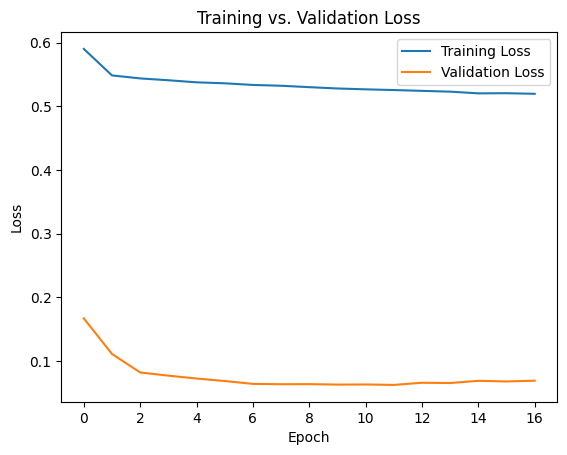

In [137]:
#########################################
# Step 5. Epoch Optimizer
#########################################
# Define optimal training and testing indices based on best split
Optimal_Training_Length = train_intervals[best_index][1]
Optimal_Testing_Start = test_intervals[best_index][0]
Optimal_Testing_End = test_intervals[best_index][1]

train_data = data.iloc[:Optimal_Training_Length]
test_data  = data.iloc[Optimal_Testing_Start:Optimal_Testing_End]

# Prepare training data
features_train = train_data[feature_cols].values
labels_train = train_data['Signal'].values
print("Number of training samples:", len(labels_train))

# Re-encode training target
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels_train)
y_train = to_categorical(integer_encoded)

# Scale training features
scaler = StandardScaler()
X_train = scaler.fit_transform(features_train)

# Build a baseline model
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64),
    LeakyReLU(alpha=0.1),
    Dense(32),
    LeakyReLU(alpha=0.1),
    Dense(3, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop])
optimal_epochs = len(history.history['loss'])
print("Optimal number of epochs:", optimal_epochs)

plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs. Validation Loss')
plt.show()

In [138]:
#########################################
# Step 6. Model tuner
#########################################
# Use Keras Tuner to search for a better model
input_shape = (X_train.shape[1],)
num_classes = y_train.shape[1]

def build_model(hp):
    model = Sequential()
    model.add(Input(shape=input_shape))
    # Tune number of hidden layers
    for i in range(hp.Int('num_layers', 1, 3)):
        units = hp.Int(f'units_{i}', min_value=32, max_value=128, step=32)
        model.add(Dense(units))
        # Tune LeakyReLU negative slope
        slope = hp.Float(f'leaky_relu_{i}', min_value=0.01, max_value=0.3, step=0.01)
        model.add(LeakyReLU(negative_slope=slope))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

tuner = kt.Hyperband(build_model, objective='val_accuracy', max_epochs=optimal_epochs,
                     factor=3, directory='kt_dir', project_name='model_complexity_tuning')
stop_early = EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train, y_train, validation_split=0.2, epochs=optimal_epochs, callbacks=[stop_early])
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters found:")
print(best_hp.values)

# Build and train the model using the tuned hyperparameters
best_model = tuner.hypermodel.build(best_hp)
best_model.summary()
history = best_model.fit(X_train, y_train, epochs=optimal_epochs, batch_size=32, validation_split=0.2)

Reloading Tuner from kt_dir\model_complexity_tuning\tuner0.json
Best hyperparameters found:
{'num_layers': 3, 'units_0': 32, 'leaky_relu_0': 0.02, 'units_1': 96, 'leaky_relu_1': 0.17, 'units_2': 96, 'leaky_relu_2': 0.23, 'tuner/epochs': 5, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}


Model: "sequential_223"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_779 (Dense)               │ (None, 32)             │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_556 (LeakyReLU)     │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_780 (Dense)               │ (None, 96)             │         3,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_557 (LeakyReLU)     │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_781 (Dense)               │ (None, 96)             │         9,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_558 (LeakyReLU)     │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_782 (Dense)               │ (None, 3)              │           291 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,187 (51.51 KB)

 Trainable params: 13,187 (51.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/17
481/481 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7739 - loss: 0.6168 - val_accuracy: 0.9901 - val_loss: 0.0745
Epoch 2/17
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7895 - loss: 0.5556 - val_accuracy: 0.9901 - val_loss: 0.0652
Epoch 3/17
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7873 - loss: 0.5455 - val_accuracy: 0.9901 - val_loss: 0.0633
Epoch 4/17
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7972 - loss: 0.5267 - val_accuracy: 0.9901 - val_loss: 0.0634
Epoch 5/17
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7926 - loss: 0.5297 - val_accuracy: 0.9901 - val_loss: 0.0692
Epoch 6/17
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7976 - loss: 0.5221 - val_accuracy: 0.9901 - val_loss: 0.0695
Epoch 7/17
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7950 - loss: 0.5161 - val_accuracy: 0.9901 - val_loss: 0.0686
Epoch 8/17
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7937 - loss: 0.5194 - val_accuracy: 0.

In [139]:
#########################################
# Step 7. Create model with optimized parameters (split, epoch, tuner)
#########################################
# In this step the final "best_model" (built from the best hyperparameters)
# is our model with optimized parameters from the best split, optimal epochs, and tuner.

 59/601 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step

C:\Users\matth\AppData\Local\Temp\ipykernel_20656\3269839268.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['asset_return'] = test_data['price_close'].pct_change()


601/601 ━━━━━━━━━━━━━━━━━━━━ 1s 826us/step

Trading Performance on Test Data:
Total PnL (percentage): 0.06%
Absolute PnL: $62.97
Annualized Sharpe Ratio: 0.1148


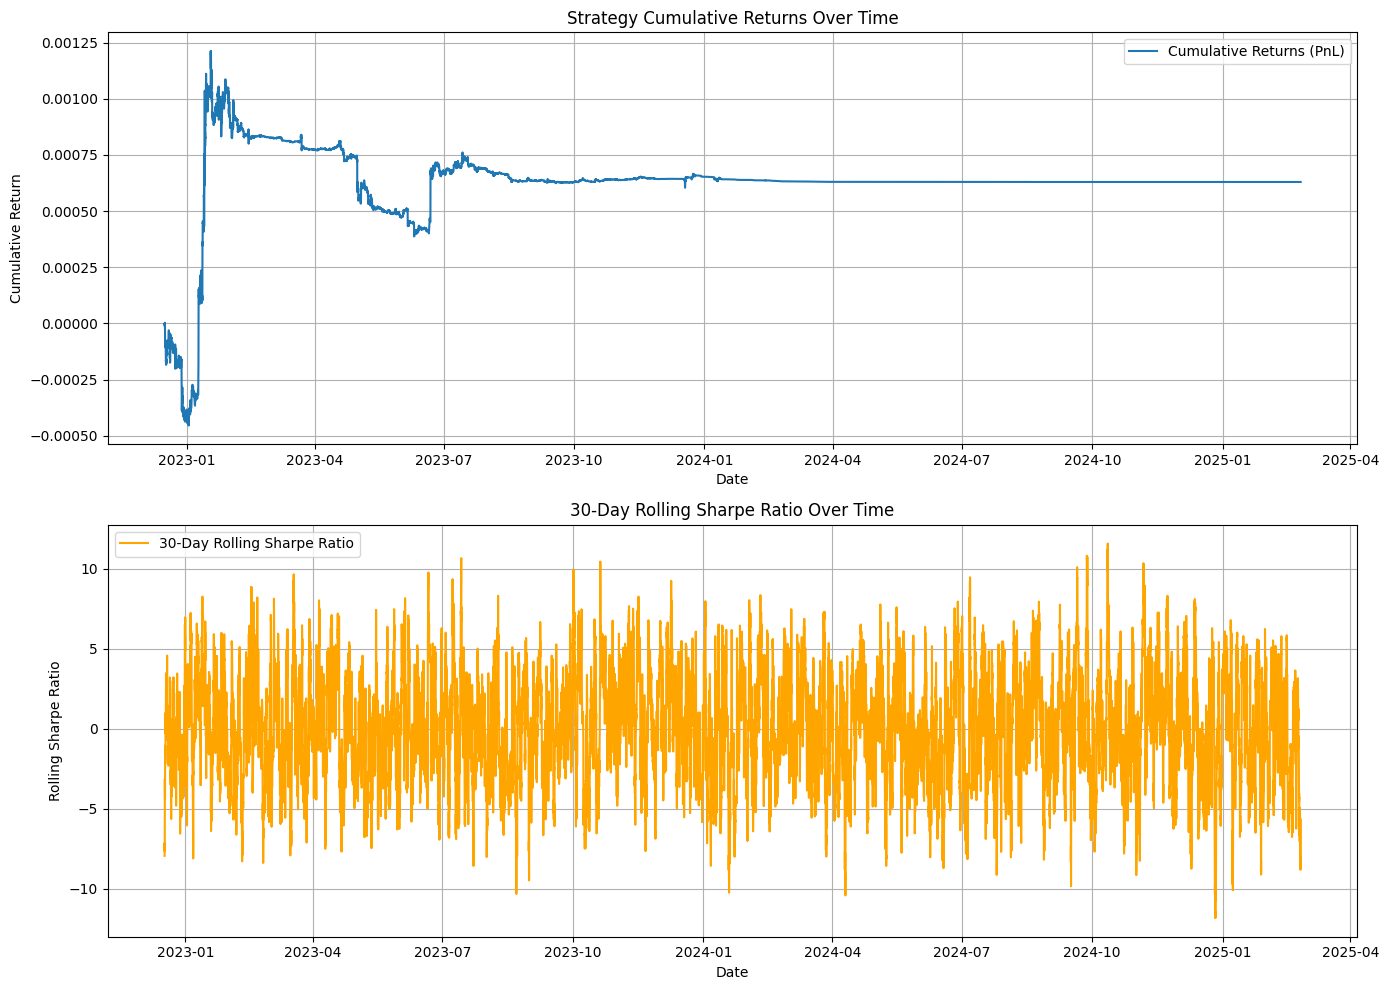

In [140]:
#########################################
# Step 8. Test model
#########################################
# Evaluate the optimized model on the test data
test_data['asset_return'] = test_data['price_close'].pct_change()
test_data = test_data.dropna()

features_test_aligned = test_data[feature_cols].values
X_test_aligned = scaler.transform(features_test_aligned)
y_pred_test_aligned = best_model.predict(X_test_aligned)
# Define positions as difference between probability of Buy and Sell
positions_test_aligned = y_pred_test_aligned[:, 0] - y_pred_test_aligned[:, 2]

asset_returns_test = test_data['asset_return'].values.astype(np.float32)
strategy_returns_test = np.roll(positions_test_aligned, shift=1) * asset_returns_test
strategy_returns_test[0] = 0

cumulative_returns_test = np.cumprod(1 + strategy_returns_test) - 1
total_pnl_percentage = cumulative_returns_test[-1]
sharpe_ratio_test = (np.mean(strategy_returns_test) / np.std(strategy_returns_test)) * np.sqrt(365)
initial_capital = 100000
absolute_pnl_test = total_pnl_percentage * initial_capital

print("\nTrading Performance on Test Data:")
print("Total PnL (percentage): {:.2%}".format(total_pnl_percentage))
print("Absolute PnL: ${:,.2f}".format(absolute_pnl_test))
print("Annualized Sharpe Ratio: {:.4f}".format(sharpe_ratio_test))

# Plot performance metrics
dates = test_data.index
cumulative_returns_series = pd.Series(cumulative_returns_test, index=dates)
returns_series = pd.Series(strategy_returns_test, index=dates)

window = 30
rolling_sharpe = returns_series.rolling(window=window).apply(
    lambda r: (np.mean(r) / np.std(r) * np.sqrt(365)) if np.std(r) != 0 else 0,
    raw=True
)

plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1)
plt.plot(cumulative_returns_series.index, cumulative_returns_series, label='Cumulative Returns (PnL)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Strategy Cumulative Returns Over Time')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(rolling_sharpe.index, rolling_sharpe, label=f'{window}-Day Rolling Sharpe Ratio', color='orange')
plt.xlabel('Date')
plt.ylabel('Rolling Sharpe Ratio')
plt.title(f'{window}-Day Rolling Sharpe Ratio Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [141]:
#########################################
# Step 9. Run the model 10 more times and show each pnl, abs pnl, and annualized sharpe
#########################################
num_runs = 10
total_pnl_list = []
absolute_pnl_list = []
sharpe_ratio_list = []

for run in range(num_runs):
    print(f"\nTraining run {run+1}/{num_runs}")
    
    # Create a new instance of the best model architecture using the tuned hyperparameters
    model_run = tuner.hypermodel.build(best_hp)
    
    # Train the new model on the training data
    model_run.fit(X_train, y_train, epochs=optimal_epochs, batch_size=32, validation_split=0.2, verbose=0)
    
    # Evaluate on the test set
    test_data_run = test_data.copy()
    test_data_run['asset_return'] = test_data_run['price_close'].pct_change()
    strategy_data = test_data_run.dropna().copy()
    
    features_test_aligned = strategy_data[feature_cols].values
    X_test_aligned = scaler.transform(features_test_aligned)
    
    y_pred_test_aligned = model_run.predict(X_test_aligned)
    # Define positions as the difference between probability of Buy (index 0) and Sell (index 2)
    positions_test_aligned = y_pred_test_aligned[:, 0] - y_pred_test_aligned[:, 2]
    
    asset_returns_test = strategy_data['asset_return'].values.astype(np.float32)
    strategy_returns_test = np.roll(positions_test_aligned, shift=1) * asset_returns_test
    strategy_returns_test[0] = 0  # adjust the first value
    
    cumulative_returns_test = np.cumprod(1 + strategy_returns_test) - 1
    total_pnl_percentage = cumulative_returns_test[-1]
    
    # Compute Sharpe ratio; handle zero standard deviation
    if np.std(strategy_returns_test) != 0:
        sharpe_ratio_test = (np.mean(strategy_returns_test) / np.std(strategy_returns_test)) * np.sqrt(365)
    else:
        sharpe_ratio_test = 0
        
    initial_capital = 100000
    absolute_pnl_test = total_pnl_percentage * initial_capital
    
    print(f"Run {run+1} Trading Performance:")
    print("  Total PnL (percentage): {:.2%}".format(total_pnl_percentage))
    print("  Absolute PnL: ${:,.2f}".format(absolute_pnl_test))
    print("  Annualized Sharpe Ratio: {:.4f}".format(sharpe_ratio_test))
    
    total_pnl_list.append(total_pnl_percentage)
    absolute_pnl_list.append(absolute_pnl_test)
    sharpe_ratio_list.append(sharpe_ratio_test)

avg_total_pnl = np.mean(total_pnl_list)
avg_absolute_pnl = np.mean(absolute_pnl_list)
avg_sharpe_ratio = np.mean(sharpe_ratio_list)

print("\nAverage Trading Performance over {} runs:".format(num_runs))
print("  Average Total PnL (percentage): {:.2%}".format(avg_total_pnl))
print("  Average Absolute PnL: ${:,.2f}".format(avg_absolute_pnl))
print("  Average Annualized Sharpe Ratio: {:.4f}".format(avg_sharpe_ratio))



Training run 1/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 1s 828us/step
Run 1 Trading Performance:
  Total PnL (percentage): 0.18%
  Absolute PnL: $182.16
  Annualized Sharpe Ratio: 0.0694

Training run 2/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 1s 840us/step
Run 2 Trading Performance:
  Total PnL (percentage): 0.49%
  Absolute PnL: $492.12
  Annualized Sharpe Ratio: 0.2653

Training run 3/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 1s 812us/step
Run 3 Trading Performance:
  Total PnL (percentage): 0.09%
  Absolute PnL: $91.48
  Annualized Sharpe Ratio: 0.2650

Training run 4/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 1s 808us/step
Run 4 Trading Performance:
  Total PnL (percentage): 0.03%
  Absolute PnL: $33.92
  Annualized Sharpe Ratio: 0.1443

Training run 5/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 1s 819us/step
Run 5 Trading Performance:
  Total PnL (percentage): 0.00%
  Absolute PnL: $0.01
  Annualized Sharpe Ratio: 0.1437

Training run 6/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 1s 811us/step
Run 6 Trading Performance:
  Total PnL (percent

In [142]:
#########################################
# Step 10. Import separate dataset (Arb)
#########################################
# Import Arb dataset (on-chain and price data)
arb1_features = pd.read_parquet('../data/on_chain_data/processed/arb1_chain_processed.parquet')
arb2_features = pd.read_parquet('../data/on_chain_data/processed/arb2_chain_processed.parquet')
arb_prices = pd.read_parquet('../data/price_data/processed/arb_processed_data.parquet')
arb_tech = pd.read_parquet('../data/data_segmented_tech/arb_data.parquet')

common_columns_arb = arb1_features.columns
arb2_features = arb2_features[common_columns_arb]
arb_features = pd.concat([arb1_features, arb2_features], ignore_index=True)

arb_prices['time_close'] = pd.to_datetime(arb_prices['time_close'])
arb_prices.set_index('time_close', inplace=True)
arb_prices.index = arb_prices.index.tz_localize('UTC')

common_length_2 = min(len(arb_prices), len(arb_features))
arb_prices_aligned = arb_prices.iloc[:common_length_2].copy()
arb_features_aligned = arb_features.iloc[:common_length_2].copy()
arb_features_aligned.index = arb_prices_aligned.index

lag_cols_2 = ['average_gas_limit', 'average_gas_used', 'average_size']
arb_features_aligned[lag_cols_2] = arb_features_aligned[lag_cols_2].shift(1)

data_2 = arb_features_aligned.join(arb_prices_aligned[['price_close']], how='inner')

common_length_tech_2 = min(len(arb_tech), len(arb_prices_aligned))
arb_tech_aligned = arb_tech.iloc[:common_length_tech_2].copy()
arb_tech_aligned.index = arb_prices_aligned.index[:common_length_tech_2]

tech_cols_2 = ['fib_23', 'fib_38', 'fib_50', 'fib_61', 'fib_78', 'bollinger', 'EMAcross', 'RSI']
arb_tech_renamed = arb_tech_aligned[tech_cols_2].rename(columns=lambda x: "tech_" + x)

data_2 = data_2.join(arb_tech_renamed, how='left')
tech_cols_renamed_2 = ["tech_" + col for col in tech_cols_2]
feature_cols_2 = lag_cols_2 + tech_cols_renamed_2

Missing features in Arb data: ['average_total_difficulty']
Out-of-Sample Classification Performance:
  Test Loss: 1909462.7500
  Test Accuracy: 0.8868
528/528 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step

Out-of-Sample Trading Performance:
  Total PnL (percentage): 0.80%
  Absolute PnL: $796.91
  Annualized Sharpe Ratio: 0.1550


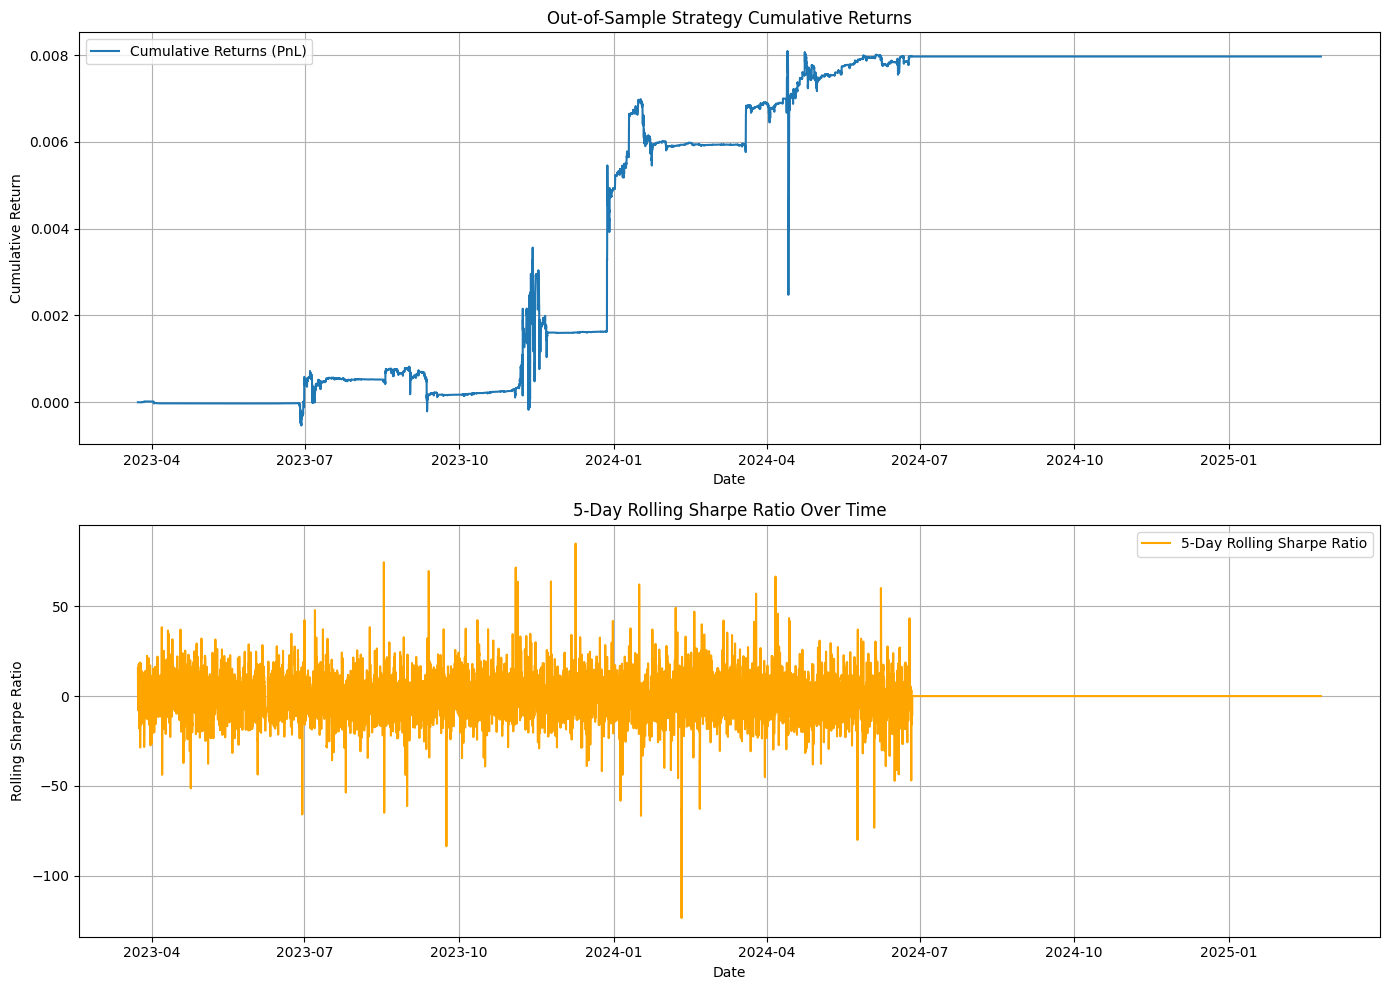

In [143]:
#########################################
# Step 11. Use Arb as an out-of-sample test
#########################################
# Generate signals on Arb data
data_2['price_diff'] = data_2['price_close'].diff()
data_2['ewma_diff'] = data_2['price_diff'].ewm(span=6, adjust=False).mean()
threshold_2 = data_2['price_diff'].std()*0.5

def get_signal(diff, threshold):
    if diff > threshold:
        return 'Buy'
    elif diff < -threshold:
        return 'Sell'
    else:
        return 'Hold'

data_2['Signal'] = data_2['ewma_diff'].apply(lambda x: get_signal(x, threshold_2))
data_2 = data_2.dropna()
data_2 = data_2.sort_index()

# Ensure that all feature columns exist in Arb data
missing_features = [col for col in feature_cols if col not in data_2.columns]
if missing_features:
    print("Missing features in Arb data:", missing_features)
    for col in missing_features:
        data_2[col] = 0
data_2 = data_2.reindex(columns=list(set(feature_cols).union(data_2.columns)), fill_value=0)

# Prepare Arb data for evaluation
features_data2 = data_2[feature_cols].values
labels_data2 = data_2['Signal'].values
integer_encoded_data2 = label_encoder.transform(labels_data2)
y_data2 = to_categorical(integer_encoded_data2)
X_data2 = scaler.transform(features_data2)

# Evaluate classification performance on Arb data
loss_data2, accuracy_data2 = best_model.evaluate(X_data2, y_data2, verbose=0)
print("Out-of-Sample Classification Performance:")
print("  Test Loss: {:.4f}".format(loss_data2))
print("  Test Accuracy: {:.4f}".format(accuracy_data2))

# Compute trading performance on Arb data
data_2['asset_return'] = data_2['price_close'].pct_change()
strategy_data2 = data_2.dropna().copy()
features_data2_aligned = strategy_data2[feature_cols].values
X_data2_aligned = scaler.transform(features_data2_aligned)
y_pred_data2 = best_model.predict(X_data2_aligned)
positions_data2 = y_pred_data2[:, 0] - y_pred_data2[:, 2]

asset_returns_data2 = strategy_data2['asset_return'].values.astype(np.float32)
strategy_returns_data2 = np.roll(positions_data2, shift=1) * asset_returns_data2
strategy_returns_data2[0] = 0

cumulative_returns_data2 = np.cumprod(1 + strategy_returns_data2) - 1
total_pnl_percentage_data2 = cumulative_returns_data2[-1]
absolute_pnl_data2 = total_pnl_percentage_data2 * initial_capital
if np.std(strategy_returns_data2) != 0:
    sharpe_ratio_data2 = (np.mean(strategy_returns_data2) / np.std(strategy_returns_data2)) * np.sqrt(365)
else:
    sharpe_ratio_data2 = 0

print("\nOut-of-Sample Trading Performance:")
print("  Total PnL (percentage): {:.2%}".format(total_pnl_percentage_data2))
print("  Absolute PnL: ${:,.2f}".format(absolute_pnl_data2))
print("  Annualized Sharpe Ratio: {:.4f}".format(sharpe_ratio_data2))

# Plot Arb performance metrics
dates = strategy_data2.index
cumulative_returns_series_data2 = pd.Series(cumulative_returns_data2, index=dates)
returns_series_data2 = pd.Series(strategy_returns_data2, index=dates)
window = 5
rolling_sharpe_data2 = returns_series_data2.rolling(window=window).apply(
    lambda r: (np.mean(r) / np.std(r) * np.sqrt(365)) if np.std(r) != 0 else 0,
    raw=True
)

plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1)
plt.plot(cumulative_returns_series_data2.index, cumulative_returns_series_data2, label='Cumulative Returns (PnL)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Out-of-Sample Strategy Cumulative Returns')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(rolling_sharpe_data2.index, rolling_sharpe_data2, label=f'{window}-Day Rolling Sharpe Ratio', color='orange')
plt.xlabel('Date')
plt.ylabel('Rolling Sharpe Ratio')
plt.title(f'{window}-Day Rolling Sharpe Ratio Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
